In [455]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch,ArrowStyle
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import cm
#from highlight_text.htext import htext, fig_htext

import importing_sb as imsb
import draw_pitch as dp

plt.style.use('football')

%matplotlib inline

In [2]:
data_dir = 'data/open-data/data/'

In [3]:
comp_data = imsb.open_data(data_dir + 'competitions.json')

In [4]:
# comp_id = 11 is La Liga, season_id = 4 is 18/19
match_data = sorted(imsb.open_data(data_dir + 'matches/11/4.json'), key = lambda x: x['match_date'])

In [5]:
event_data = []
lineup_data =[]
for match in match_data:
    event_data.append(imsb.open_data(data_dir + 'events/{}.json'.format(match['match_id'])))
    lineup_data.append(imsb.open_data(data_dir + 'lineups/{}.json'.format(match['match_id'])))

In [490]:
comp = 'La Liga'
season = '18/19'
team = 'home'
date = match_data[0]['match_date']

In [463]:
nicknames = {}
if team == 'home':
    team_name = lineup_data[0][0]['team_name']
    opp_name = lineup_data[0][1]['team_name']
    players = [player['player']['name'] for player in event_data[0][0]['tactics']['lineup']]
    numbers = [number['jersey_number'] for number in event_data[0][0]['tactics']['lineup']]
    for player in lineup_data[0][0]['lineup']:
        if player['player_nickname'] == None:
            nicknames[str(player['player_name'])] = str(player['player_name'])
        else:
            nicknames[str(player['player_name'])] = str(player['player_nickname'])
if team == 'away':
    team_name = lineup_data[0][1]['team_name']
    opp_name = lineup_data[0][0]['team_name']
    players = [player['player']['name'] for player in event_data[0][1]['tactics']['lineup']]
    numbers = [number['jersey_number'] for number in event_data[0][1]['tactics']['lineup']]
    for player in lineup_data[0][1]['lineup']:
        if player['player_nickname'] == None:
            nicknames[str(player['player_name'])] = str(player['player_name'])
        else:
            nicknames[str(player['player_name'])] = str(player['player_nickname'])

In [437]:
dict_num = {players[i]:numbers[i] for i in range(len(players))}

In [6]:
"""nicknames = {}
for match in lineup_data:
    for team in match:
        if team['team_name'] == 'Barcelona':
            for players in team['lineup']:
                if players['player_nickname'] == None:
                    nicknames[str(players['player_name'])] = str(players['player_name'])
                else:
                    nicknames[str(players['player_name'])] = str(players['player_nickname'])"""

To begin I will use the first match of the of the La Liga 18/19 season for testing.

In [7]:
"""# Find the starting 11 and shirt numbers
for i in range(2):
    if event_data[0][i]['team']['name'] == 'Barcelona':
        players = [player['player']['name'] for player in event_data[0][i]['tactics']['lineup']]
        numbers = [number['jersey_number'] for number in event_data[0][i]['tactics']['lineup']]"""

In [438]:
df = imsb.get_pass(event_data[0])
df['y'] = df['y'].apply(lambda y: 80-y) # Flipping y coord for plotting
df['end_y'] = df['end_y'].apply(lambda y: 80-y) # Flipping y coord for plotting
df = df[df['outcome'] == 'Complete'] # Taking only complete passes
df = df[df['pass_type'] == 'Standard'] # Only standard, open play passes
df = df[df['team'] == team_name] # Only Barca passes
df = df[df['player'].isin(players)] # keep passers only in starting 11
df = df[df['recipient'].isin(players)] # keep recipients only in starting 11
df.drop(['index','event_id','minute','second','type','duration','cross','cutback','switch','technique'],axis=1,
       inplace=True)

In [439]:
df.columns

Index(['period', 'pos_team', 'play_pattern', 'team', 'player', 'x', 'y',
       'end_x', 'end_y', 'length', 'angle', 'height', 'recipient',
       'under_pressure', 'shot_assist', 'goal_assist', 'xA', 'body_part',
       'pass_type', 'outcome', 'progressive'],
      dtype='object')

Get average player positions of the starting 11 using the positions the played and received passes.

In [441]:
# Create df where index is player name with average x and y columns
x_list = []
y_list = []
player_loc = pd.DataFrame(index=players)
dict_loc = {}
for player in players:
    loc1 = df[df['player'] == player][['x','y']]
    loc2 = df[df['recipient'] == player][['end_x','end_y']].rename(columns={'end_x':'x','end_y':'y'})
    loc = pd.concat([loc1,loc2]).mean()
    x_list.append(loc['x'])
    y_list.append(loc['y'])
    dict_loc[player] = (loc['x'],loc['y'])
player_loc['x'] = x_list
player_loc['y'] = y_list

In [442]:
df.head()

,period,pos_team,play_pattern,team,player,x,y,end_x,end_y,length,...,height,recipient,under_pressure,shot_assist,goal_assist,xA,body_part,pass_type,outcome,progressive
3,1,Barcelona,Regular Play,Barcelona,Ivan Rakitić,36.0,59.0,36.0,78.0,19.000000,...,Low Pass,Ousmane Dembélé,False,None,None,NaN,Head,Standard,Complete,False
4,1,Barcelona,Regular Play,Barcelona,Ousmane Dembélé,34.0,77.0,26.0,78.0,8.062258,...,Ground Pass,Jordi Alba Ramos,True,None,None,NaN,Right Foot,Standard,Complete,False
7,1,Barcelona,Regular Play,Barcelona,Marc-André ter Stegen,14.0,52.0,23.0,36.0,18.357560,...,Ground Pass,Gerard Piqué Bernabéu,False,None,None,NaN,Keeper Arm,Standard,Complete,False
8,1,Barcelona,Regular Play,Barcelona,Gerard Piqué Bernabéu,35.0,26.0,44.0,8.0,20.124610,...,Ground Pass,Nélson Cabral Semedo,False,None,None,NaN,Right Foot,Standard,Complete,False
9,1,Barcelona,Regular Play,Barcelona,Nélson Cabral Semedo,50.0,8.0,57.0,17.0,11.401754,...,Ground Pass,Sergi Roberto Carnicer,False,None,None,NaN,Right Foot,Standard,Complete,False


In [443]:
df.groupby('player').size()

player
Gerard Piqué Bernabéu              64
Ivan Rakitić                      120
Jordi Alba Ramos                   73
Lionel Andrés Messi Cuccittini     57
Luis Alberto Suárez Díaz           25
Marc-André ter Stegen              18
Nélson Cabral Semedo               23
Ousmane Dembélé                    43
Samuel Yves Umtiti                 51
Sergi Roberto Carnicer             68
Sergio Busquets i Burgos           65
dtype: int64

Create a Player class containing name, nickname, shirt number, average location, total number of passes.

In [444]:
class Player:
    def __init__(self, player, nicknames, dict_num, dict_loc, df_passes):
        self.name = player
        self.nickname = nicknames[player]
        self.number = dict_num[player]
        self.loc = dict_loc[player]
        self.pass_count = df.groupby('player').size()[player]

## Separating pass amounts by passer and receiver

In [445]:
df_player = df.set_index(['player','recipient']).sort_index()

In [446]:
df_player_count = df.groupby(['player','recipient']).size()

In [447]:
df_player.head()

period   pos_team   play_pattern  \
player                recipient                                        
Gerard Piqué Bernabéu Ivan Rakitić       1  Barcelona   Regular Play   
                      Ivan Rakitić       1  Barcelona   Regular Play   
                      Ivan Rakitić       1  Barcelona  From Throw In   
                      Ivan Rakitić       1  Barcelona   Regular Play   
                      Ivan Rakitić       1  Barcelona   Regular Play   

                                         team     x     y  end_x  end_y  \
player                recipient                                           
Gerard Piqué Bernabéu Ivan Rakitić  Barcelona  29.0  40.0   39.0   54.0   
                      Ivan Rakitić  Barcelona  63.0  16.0   66.0   49.0   
                      Ivan Rakitić  Barcelona  72.0  27.0   78.0   54.0   
                      Ivan Rakitić  Barcelona  78.0  32.0   84.0   54.0   
                      Ivan Rakitić  Barcelona  40.0  28.0   49.0   49.0   

                                       length     angle       height  \
player                recipient                                        
Gerard Piqué Bernabéu Ivan Rakitić  17.204650 -0.950547  Ground Pass   
                      Ivan Rakitić  33.136080 -1.480136  Ground Pass   
                      Ivan Rakitić  27.658634 -1.352127  Ground Pass   
                      Ivan Rakitić  22.803509 -1.304544  Ground Pass   
                      Ivan Rakitić  22.847319 -1.165904  Ground Pass   

                                    under_pressure shot_assist goal_assist  \
player                recipient                                              
Gerard Piqué Bernabéu Ivan Rakitić           False        None        None   
                      Ivan Rakitić           False        None        None   
                      Ivan Rakitić           False        None        None   
                      Ivan Rakitić           False        None        None   
                      Ivan Rakitić           False        None        None   

                                    xA   body_part pass_type   outcome  \
player                recipient                                          
Gerard Piqué Bernabéu Ivan Rakitić NaN  Right Foot  Standard  Complete   
                      Ivan Rakitić NaN  Right Foot  Standard  Complete   
                      Ivan Rakitić NaN  Right Foot  Standard  Complete   
                      Ivan Rakitić NaN  Right Foot  Standard  Complete   
                      Ivan Rakitić NaN  Right Foot  Standard  Complete   

                                    progressive  
player                recipient                  
Gerard Piqué Bernabéu Ivan Rakitić        False  
                      Ivan Rakitić        False  
                      Ivan Rakitić        False  
                      Ivan Rakitić        False  
                      Ivan Rakitić        False

In [448]:
df_player_count

player                    recipient                     
Gerard Piqué Bernabéu     Ivan Rakitić                      10
                          Jordi Alba Ramos                   4
                          Lionel Andrés Messi Cuccittini     6
                          Luis Alberto Suárez Díaz           1
                          Marc-André ter Stegen              3
                                                            ..
Sergio Busquets i Burgos  Luis Alberto Suárez Díaz           2
                          Nélson Cabral Semedo               4
                          Ousmane Dembélé                    6
                          Samuel Yves Umtiti                 3
                          Sergi Roberto Carnicer             7
Length: 89, dtype: int64

## Using total passes between players

For this plot I will use the total amount of passes between pairs of players, disregarding the specifics of passer and receiver.

In [449]:
player_list = []
player1 = []
player2 = []
total = []
for i in players:
    for j in players:
        if j in player_list:
            continue
        if i == j:
            continue
        if j in df_player_count.loc[i].index and i in df_player_count.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player_count.loc[i,j]+df_player_count.loc[j,i])
        elif j in df_player_count[i].index and i not in df_player_count.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player_count.loc[i,j])
        elif j not in df_player_count.loc[i].index and i in df_player_count.loc[j].index:
            player1.append(i)
            player2.append(j)
            total.append(df_player_count.loc[j,i])
            
    player_list.append(i)

In [450]:
df_pair_count = pd.DataFrame({'player1':player1,'player2':player2,'total':total})

In [451]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

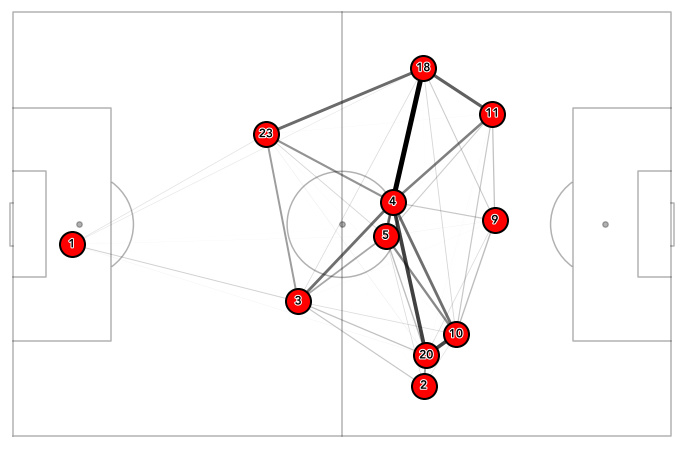

In [456]:
max_pair_count = df_pair_count['total'].max()
max_edge_width = 5
min_edge_width = 0.1

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
# Plot nodes
for i in players:
    p = Player(i, nicknames, dict_num, dict_loc,df)
    ax.plot(p.loc[0],p.loc[1],'.',markersize=50,c='r',mec='k',zorder=10)
    ax.annotate(p.number,p.loc,c='k',ha='center',va='center',size=12,
                fontweight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)

for i,row in df_pair_count.iterrows():
    p1 = Player(row['player1'], nicknames, dict_num, dict_loc,df)
    p2 = Player(row['player2'], nicknames, dict_num, dict_loc,df)
    loc = [[p1.loc[0],p2.loc[0]],[p1.loc[1],p2.loc[1]]]
    num_passes = row['total']
    # Plot edges
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    alpha = change_range(num_passes,(0,max_pair_count),(0,1))
    ax.plot(loc[0],loc[1],'k-',lw=line_width,alpha=alpha,zorder=9)

Pass amount by colour.

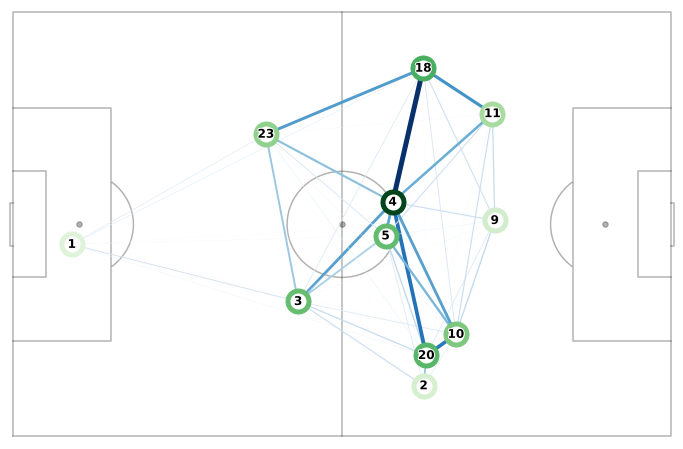

In [289]:
max_play_count = df.groupby('player').size().max()
min_play_count = df.groupby('player').size().min()
max_pair_count = df_pair_count['total'].max()
max_edge_width = 5
min_edge_width = 0.1

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)

# Plot nodes
node_norm = Normalize(0,max_play_count)
node_cmap = cm.get_cmap('Greens')
for i in players:
    marker_size = 50
    inner_marker_size = 30
    p = Player(i, nicknames, dict_num, dict_loc, df)
    node_colour = node_cmap(node_norm(p.pass_count))
    ax.plot(p.loc[0],p.loc[1],'.',markersize=marker_size,c=node_colour,zorder=10)
    ax.plot(p.loc[0],p.loc[1],'.',markersize=inner_marker_size,c='w',zorder=11)
    ax.annotate(p.number,p.loc,ha='center',va='center',size=12,fontweight='bold',
                path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)

# Plot edges
edge_norm = Normalize(0,max_pair_count)
edge_cmap = cm.get_cmap('Blues')
for i,row in df_pair_count.iterrows():
    p1 = Player(row['player1'], nicknames, dict_num, dict_loc, df)
    p2 = Player(row['player2'], nicknames, dict_num, dict_loc, df)
    loc = [[p1.loc[0],p2.loc[0]],[p1.loc[1],p2.loc[1]]]
    num_passes = row['total']
    edge_colour = edge_cmap(edge_norm(num_passes))
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    ax.plot(loc[0],loc[1],'k-',lw=line_width,c=edge_colour,zorder=9)
    
plt.show()

## Separating by passer and recipient

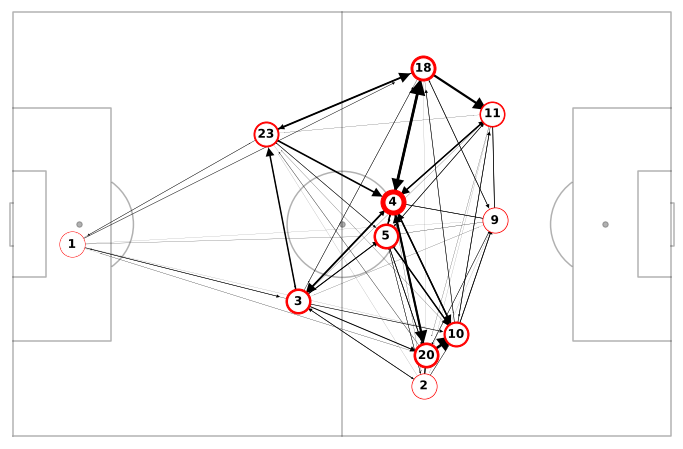

In [298]:
max_play_count = df.groupby('player').size().max()
min_play_count = df.groupby('player').size().min()
max_pair_count = df_player_count.max()
max_edge_width = 0.5
min_edge_width = 0
min_inner_node_size = 30
max_inner_node_size = 48
max_node_size = 70
min_node_size = 40

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
# Plot nodes
for i in players:
    p = Player(i, nicknames, dict_num, dict_loc,df)
    marker_size = 50
    inner_marker_size = change_range(p.pass_count,(min_play_count,max_play_count),(max_inner_node_size,min_inner_node_size))
    ax.plot(p.loc[0],p.loc[1],'.',markersize=marker_size,c='r',zorder=10)
    ax.plot(p.loc[0],p.loc[1],'.',markersize=inner_marker_size,c='w',mew=1,zorder=11)
    ax.annotate(p.number,p.loc,ha='center',va='center',size=12,
                fontweight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)

# Plot edges
for i,value in df_player_count.iteritems():
    p1 = Player(i[0], nicknames, dict_num, dict_loc, df)
    p2 = Player(i[1], nicknames, dict_num, dict_loc, df)
    loc = [[p1.loc[0],p2.loc[0]],[p1.loc[1],p2.loc[1]]]
    num_passes = value
    line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
    ax.arrow(loc[0][0],loc[1][0],0.92*(loc[0][1]-loc[0][0]),0.92*(loc[1][1]-loc[1][0]),
             length_includes_head=True,width=line_width,head_width=6*line_width,
             head_length=6*line_width,fc='k',lw=0)

plt.show()
    
#style = ArrowStyle("Simple",head_length=10, head_width=10, tail_width=2)
#arrow = FancyArrowPatch((loc[0][0],loc[1][0]),(loc[0][1],loc[1][1]),arrowstyle=style,mutation_scale=1,fc='k')
#ax.add_patch(arrow)

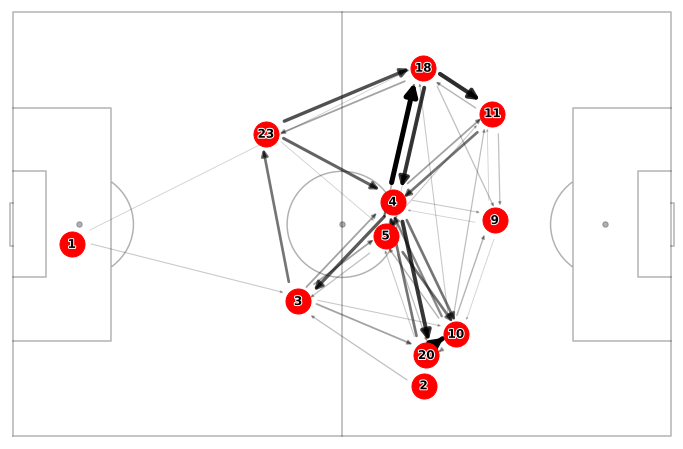

In [353]:
max_pair_count = df_player_count.max()
max_edge_width = 5
min_edge_width = 0
arr_shift = 1
pass_count_threshold = 5

fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
# Plot nodes
for i in players:
    p = Player(i, nicknames, dict_num, dict_loc,df)
    marker_size = 50
    inner_marker_size = change_range(p.pass_count,(min_play_count,max_play_count),(max_inner_node_size,min_inner_node_size))
    ax.plot(p.loc[0],p.loc[1],'.',markersize=marker_size,c='r',mec='r',mew=1,zorder=10)
    ax.annotate(p.number,p.loc,ha='center',va='center',size=12,
                fontweight='bold',path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)
    
for i,value in df_player_count.iteritems():
    if value < pass_count_threshold:
        continue
    
    pas = Player(i[0], nicknames, dict_num, dict_loc,df)
    rec = Player(i[1], nicknames, dict_num, dict_loc,df)

    lw = change_range(value,(0,max_pair_count),(min_edge_width,max_edge_width))
    alpha = change_range(value,(0,max_pair_count),(0,1))
    
    # Shift arrow vertically if diff in x > diff in y
    if abs(rec.loc[0]-pas.loc[0]) > abs(rec.loc[1]-pas.loc[1]):
        # Passes played by the player will always be on left of passes received
        if pas.loc[0] <= rec.loc[0]:
            ax.annotate("",xy=(rec.loc[0],rec.loc[1]+arr_shift),xytext=(pas.loc[0],pas.loc[1]+arr_shift),
                        arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                        shrinkA=20,shrinkB=15,lw=lw,fc='k',alpha=alpha))
        else:
            ax.annotate("",xy=(rec.loc[0],rec.loc[1]-arr_shift),xytext=(pas.loc[0],pas.loc[1]-arr_shift),
                                arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                shrinkA=20,shrinkB=15,lw=lw,fc='k',alpha=alpha))
            
    # Shift arrow horizontally if diff in x <= diff in y
    elif abs(rec.loc[0]-pas.loc[0]) <= abs(rec.loc[1]-pas.loc[1]):
        # Again ensuring passes played by the player will always be on left of passes received
        if pas.loc[1] > rec.loc[1]:
            ax.annotate("",xy=(rec.loc[0]+arr_shift,rec.loc[1]),xytext=(pas.loc[0]+arr_shift,pas.loc[1]),
                        arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                        shrinkA=20,shrinkB=15,lw=lw,color='k',alpha=alpha))
        else:
            ax.annotate("",xy=(rec.loc[0]-arr_shift,rec.loc[1]),xytext=(pas.loc[0]-arr_shift,pas.loc[1]),
                                arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                shrinkA=20,shrinkB=15,lw=lw,color='k',alpha=alpha))
            
plt.show()

## Combining everything into a function

In [728]:
def draw_pass_network(edge_type="combined",colours=False,nc='r',ec='k',tc='k',ns=50,n_cmap='Greens',e_cmap='Blues',
                     pass_count_threshold=5):
    """
    Plot a passing network.
    """
    max_play_count = df.groupby('player').size().max()
    min_play_count = df.groupby('player').size().min()
    max_pair_count = df_pair_count['total'].max()
    min_pair_count = df_pair_count['total'].min()
    max_pair_count_separate = df_player_count.max()
    max_edge_width = 5
    min_edge_width = 0.1
    arr_shift = 1
    
    fig,ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
    
    if edge_type == "combined":
        ### Count total passes between pairs ###
        if colours is False:
            # Plot nodes
            for i in players:
                p = Player(i, nicknames, dict_num, dict_loc,df)
                ax.plot(p.loc[0],p.loc[1],'.',markersize=50,c=nc,mec='k',zorder=10)
                ax.annotate(p.number,p.loc,c=tc,ha='center',va='center',size=12,fontweight='bold',
                            path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)
            # Plot edges
            for i,row in df_pair_count.iterrows():
                if row['total'] < pass_count_threshold:
                    continue
                p1 = Player(row['player1'], nicknames, dict_num, dict_loc,df)
                p2 = Player(row['player2'], nicknames, dict_num, dict_loc,df)
                loc = [[p1.loc[0],p2.loc[0]],[p1.loc[1],p2.loc[1]]]
                num_passes = row['total']
                lw = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
                alpha = change_range(num_passes,(0,max_pair_count),(0,1))
                ax.plot(loc[0],loc[1],c=ec,ls='-',lw=lw,alpha=alpha,zorder=9)
                
        elif colours is True:
            # Plot nodes
            node_norm = Normalize(0,max_play_count)
            node_cmap = cm.get_cmap(n_cmap)
            for i in players:
                inner_marker_size = (3/5)*ns
                p = Player(i, nicknames, dict_num, dict_loc, df)
                node_colour = node_cmap(node_norm(p.pass_count))
                ax.plot(p.loc[0],p.loc[1],'.',markersize=ns,c=node_colour,mec='k',mew=0.5,zorder=10)
                ax.plot(p.loc[0],p.loc[1],'.',markersize=inner_marker_size,c='w',mec='k',mew=0.5,zorder=11)
                ax.annotate(p.number,p.loc,c=tc,ha='center',va='center',size=12,fontweight='bold',
                            path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)

            # Plot edges
            edge_norm = Normalize(0,max_pair_count)
            edge_cmap = cm.get_cmap(e_cmap)
            for i,row in df_pair_count.iterrows():
                if row['total'] < pass_count_threshold:
                    continue
                p1 = Player(row['player1'], nicknames, dict_num, dict_loc, df)
                p2 = Player(row['player2'], nicknames, dict_num, dict_loc, df)
                loc = [[p1.loc[0],p2.loc[0]],[p1.loc[1],p2.loc[1]]]
                num_passes = row['total']
                edge_colour = edge_cmap(edge_norm(num_passes))
                line_width = change_range(num_passes,(0,max_pair_count),(min_edge_width,max_edge_width))
                ax.plot(loc[0],loc[1],'k-',lw=line_width,c=edge_colour,zorder=9)
    
        else:
            print("Please enter True or False for colours.")
            
    else:
        ### Separate passes played and received ###
        if colours is False:
            # Plot nodes
            for i in players:
                p = Player(i, nicknames, dict_num, dict_loc, df)
                ax.plot(p.loc[0],p.loc[1],'.',markersize=ns,c=nc,zorder=10)
                ax.annotate(p.number,p.loc,c=tc,ha='center',va='center',size=12,fontweight='bold',
                            path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)
                
            # Plot edges
            for i,value in df_player_count.iteritems():
                if value < pass_count_threshold:
                    continue

                pas = Player(i[0], nicknames, dict_num, dict_loc,df)
                rec = Player(i[1], nicknames, dict_num, dict_loc,df)

                lw = change_range(value,(0,max_pair_count_separate),(min_edge_width,max_edge_width))
                alpha = change_range(value,(0,max_pair_count_separate),(0,1))

                # Shift arrow vertically if diff in x > diff in y
                if abs(rec.loc[0]-pas.loc[0]) > abs(rec.loc[1]-pas.loc[1]):
                    # Passes played by the player will always be on left of passes received
                    if pas.loc[0] <= rec.loc[0]:
                        ax.annotate("",xy=(rec.loc[0],rec.loc[1]+arr_shift),xytext=(pas.loc[0],pas.loc[1]+arr_shift),
                                    arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                    shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))
                    else:
                        ax.annotate("",xy=(rec.loc[0],rec.loc[1]-arr_shift),xytext=(pas.loc[0],pas.loc[1]-arr_shift),
                                            arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                            shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))

                # Shift arrow horizontally if diff in x <= diff in y
                elif abs(rec.loc[0]-pas.loc[0]) <= abs(rec.loc[1]-pas.loc[1]):
                    # Again ensuring passes played by the player will always be on left of passes received
                    if pas.loc[1] > rec.loc[1]:
                        ax.annotate("",xy=(rec.loc[0]+arr_shift,rec.loc[1]),xytext=(pas.loc[0]+arr_shift,pas.loc[1]),
                                    arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                    shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))
                    else:
                        ax.annotate("",xy=(rec.loc[0]-arr_shift,rec.loc[1]),xytext=(pas.loc[0]-arr_shift,pas.loc[1]),
                                            arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                            shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))
            
        elif colours is True:
            # Plot nodes
            node_norm = Normalize(0,max_play_count)
            node_cmap = cm.get_cmap(n_cmap)
            for i in players:
                inner_marker_size = (3/5)*ns
                p = Player(i, nicknames, dict_num, dict_loc, df)
                node_colour = node_cmap(node_norm(p.pass_count))
                ax.plot(p.loc[0],p.loc[1],'.',markersize=ns,c=node_colour,mec='k',mew=0.5,zorder=10)
                ax.plot(p.loc[0],p.loc[1],'.',markersize=inner_marker_size,c='w',mec='k',mew=0.5,zorder=11)
                ax.annotate(p.number,p.loc,c=tc,ha='center',va='center',size=12,fontweight='bold',
                            path_effects=[pe.withStroke(linewidth=2,foreground='w')],zorder=12)
                
            # Plot edges
            edge_norm = Normalize(0,max_pair_count_separate)
            edge_cmap = cm.get_cmap(e_cmap)
            for i,value in df_player_count.iteritems():
                if value < pass_count_threshold:
                    continue

                pas = Player(i[0], nicknames, dict_num, dict_loc, df)
                rec = Player(i[1], nicknames, dict_num, dict_loc, df)
                
                ec = edge_cmap(edge_norm(value))
                lw = change_range(value,(0,max_pair_count_separate),(min_edge_width,max_edge_width))
                alpha = change_range(value,(0,max_pair_count_separate),(0,1))

                # Shift arrow vertically if diff in x > diff in y
                if abs(rec.loc[0]-pas.loc[0]) > abs(rec.loc[1]-pas.loc[1]):
                    # Passes played by the player will always be on left of passes received
                    if pas.loc[0] <= rec.loc[0]:
                        ax.annotate("",xy=(rec.loc[0],rec.loc[1]+arr_shift),xytext=(pas.loc[0],pas.loc[1]+arr_shift),
                                    arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                    shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))
                    else:
                        ax.annotate("",xy=(rec.loc[0],rec.loc[1]-arr_shift),xytext=(pas.loc[0],pas.loc[1]-arr_shift),
                                            arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                            shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))

                # Shift arrow horizontally if diff in x <= diff in y
                elif abs(rec.loc[0]-pas.loc[0]) <= abs(rec.loc[1]-pas.loc[1]):
                    # Again ensuring passes played by the player will always be on left of passes received
                    if pas.loc[1] > rec.loc[1]:
                        ax.annotate("",xy=(rec.loc[0]+arr_shift,rec.loc[1]),xytext=(pas.loc[0]+arr_shift,pas.loc[1]),
                                    arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                    shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))
                    else:
                        ax.annotate("",xy=(rec.loc[0]-arr_shift,rec.loc[1]),xytext=(pas.loc[0]-arr_shift,pas.loc[1]),
                                            arrowprops=dict(arrowstyle='-|>,head_length={},head_width={}'.format(0.2*lw,0.1*lw),
                                                            shrinkA=20,shrinkB=15,lw=lw,color=ec,alpha=alpha))
        
        else:
            print("Please enter True or False for colours.")
            
    ax.text(0,88,"{} - Pass Network".format(team_name),fontsize=20,fontweight='bold')
    ax.text(0,83,"vs {} | {} | {}".format(opp_name,comp,date),fontsize=16)
    
    if colours is True:
        nc_ex = [node_cmap(node_norm(min_play_count)),node_cmap(node_norm((max_play_count-min_play_count)/2)),
                 node_cmap(node_norm(max_play_count))]
        nc_ex_val = [min_play_count,(max_play_count-min_play_count)/2,max_play_count]
        x_ex = [3,5,7]
        y_ex = [5,5,5]
        ax2 = fig.add_axes([0.71,0.90,0.2,0.05])
        ax2.set_xlim(0,10)
        ax2.set_ylim(0,10)
        ax2.axis('off')
        ax2.text(5,12,"Pass number by player",ha='center',fontsize=13)
        for i in range(len(x_ex)):
            ax2.plot(x_ex[i],y_ex[i],'.',markersize=ns,c=nc_ex[i],mec='k',mew=0.5,zorder=10)
            ax2.plot(x_ex[i],y_ex[i],'.',markersize=inner_marker_size,c='w',mec='k',mew=0.5,zorder=10)
            ax2.text(x_ex[i],-4,"{:.0f}".format(np.ceil(nc_ex_val[i])),ha='center',fontsize=12)
            
        ec_ex = [edge_cmap(edge_norm(min_pair_count)),edge_cmap(edge_norm((max_pair_count-min_pair_count)/2)),
                 edge_cmap(edge_norm(max_pair_count))]
        ec_ex_val = [min_pair_count,(max_pair_count-min_pair_count)/2,max_pair_count]
        x_ex = [[1,3],[4,6],[7,9]]
        y_ex = [[5,5],[5,5],[5,5]]
        ax3 = fig.add_axes([0.51,0.90,0.2,0.05])
        ax3.set_xlim(0,10)
        ax3.set_ylim(0,10)
        ax3.axis('off')
        ax3.text(5,12,"Pass number between players",ha='center',fontsize=13)
        for i in range(len(x_ex)):
            ax3.plot(x_ex[i],y_ex[i],'-',markersize=ns,c=ec_ex[i],lw=4,zorder=10,
                     path_effects=[pe.Stroke(linewidth=6,foreground='k'), pe.Normal()])
            ax3.text(x_ex[i][0]+1,-1,"{:.0f}".format(np.ceil(ec_ex_val[i])),ha='center',fontsize=12)
            
    plt.show()

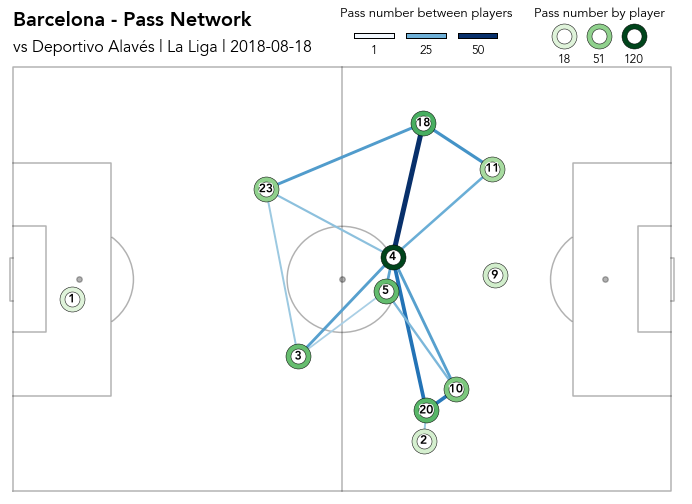

In [751]:
draw_pass_network(edge_type='combined',colours=True,pass_count_threshold=15)

Add legend to colours=False pass networks.